In [1]:
%matplotlib inline

from IPython import display
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# overwrite ipython defaults
plt.rcParams["figure.facecolor"] = 'e7eaec'
plt.rcParams["axes.facecolor"] = 'e7eaec'
plt.rcParams["figure.figsize"] = (10, 8)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Yelp reviews appear as a single JSON object per line in the file.
# Write the first line of the review file to look at the structure.
! head -n 1 data/yelp_academic_dataset_review.json

{"votes": {"funny": 0, "useful": 0, "cool": 0}, "user_id": "P_Mk0ygOilLJo4_WEvabAA", "review_id": "OeT5kgUOe3vcN7H6ImVmZQ", "stars": 3, "date": "2005-08-26", "text": "This is a pretty typical cafe.  The sandwiches and wraps are good but a little overpriced and the food items are the same.  The chicken caesar salad wrap is my favorite here but everything else is pretty much par for the course.", "type": "review", "business_id": "Jp9svt7sRT4zwdbzQ8KQmw"}


In [3]:
id_map = pd.read_csv("data/restaurant_ids_to_yelp_ids.csv")
id_dict = {}

# each Yelp ID may correspond to up to 4 Boston IDs
for i, row in id_map.iterrows():
    # get the Boston ID
    boston_id = row["restaurant_id"]
    
    # get the non-null Yelp IDs
    non_null_mask = ~pd.isnull(row.ix[1:])
    yelp_ids = row[1:][non_null_mask].values
    
    for yelp_id in yelp_ids:
        id_dict[yelp_id] = boston_id

In [4]:
    with open("data/yelp_academic_dataset_review.json", 'r') as review_file:
        # the file is not actually valid json since each line is an individual
        # dict -- we will add brackets on the very beginning and ending in order
        # to make this an array of dicts and join the array entries with commas
        review_json = '[' + ','.join(review_file.readlines()) + ']'
    # read in the json as a DataFrame
    reviews = pd.read_json(review_json)

    # replace yelp business_id with boston restaurant_id
    map_to_boston_ids = lambda yelp_id: id_dict[yelp_id] if yelp_id in id_dict else np.nan
    reviews.business_id = reviews.business_id.map(map_to_boston_ids)

    # rename first column to restaurant_id so we can join with boston data
    reviews.columns = ["restaurant_id", "review_date", "review_id", "stars", "text", "type", "user_id", "votes"]

    # drop restaurants not found in boston data
    reviews = reviews[pd.notnull(reviews.restaurant_id)]

In [5]:
train_labels = pd.read_csv("data/train_labels.csv", index_col=0)
submission = pd.read_csv("data/SubmissionFormat.csv", index_col=0)
train_labels.head()

,date,restaurant_id,*,**,***
id,,,,,
589,2010-02-02,KAoKWjog,3,0,1
28589,2009-12-10,p038M4om,2,0,0
31170,2008-07-16,B1oXymOV,4,0,0
2600,2015-01-30,m0oWJl3G,1,0,3
1016,2012-03-19,rJoQwlEV,0,0,0


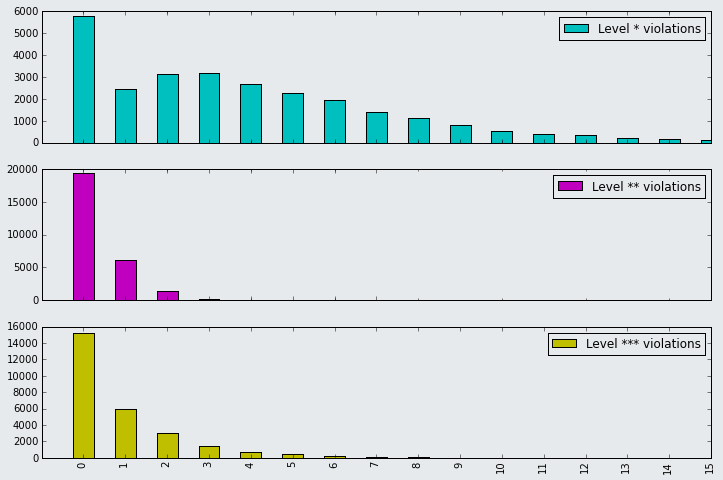

In [28]:
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(12, 8)

for i, label in enumerate(['*', '**', '***']):
    data = train_labels[label]
    vc = data.value_counts()
    idxs = sorted(vc.index)
    vc[idxs].plot(kind="bar",
                  ax=axs[i],
                  xlim=(-1, 15),
                  color=plt.rcParams['axes.color_cycle'][i+3],
                  grid=False,
                  label='Level {} violations'.format(label))
    axs[i].legend()

In [6]:
# a simple way to create a "document" for an inspection is to
# concatenate all the reviews that happened before the inspection date
def flatten_reviews(label_df, reviews):
    """ label_df: inspection dataframe with date, restaurant_id
        reviews: dataframe of reviews
        
        Returns all of the text of reviews previous to each
        inspection listed in label_df.
    """
    reviews_dictionary = {}
    
    N = len(label_df)

    for i, (pid, row) in enumerate(label_df.iterrows()):
        # we want to only get reviews for this restaurant that ocurred before the inspection
        pre_inspection_mask = (reviews.date < row.date) & (reviews.restaurant_id == row.restaurant_id)
        
        # pre-inspection reviews
        pre_inspection_reviews = reviews[pre_inspection_mask]
        
        # join the text
        all_text = ' '.join(pre_inspection_reviews.text)

        # store in dictionary
        reviews_dictionary[pid] = all_text
        
        if i % 2500 == 0:
            print '{} out of {}'.format(i, N)

    # return series in same order as the original data frame
    return pd.Series(reviews_dictionary)[label_df.index]

In [30]:
train_text = flatten_reviews(train_labels, reviews)
train_text.head()

0 out of 27088
2500 out of 27088
5000 out of 27088
7500 out of 27088
10000 out of 27088
12500 out of 27088
15000 out of 27088
17500 out of 27088
20000 out of 27088
22500 out of 27088
25000 out of 27088


id
589      i'm posting this review on behalf of my boyfri...
28589    A great addition to Peabody Square! It is an u...
31170    This is definitely the best place to eat in Bo...
2600     Well, it's nothing spectacular, but if you're ...
1016     The thinking cup has a great atmosphere, I wou...
dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
import text_processors
vec, train_tfidf = text_processors.tfidf_custom_token_and_save(train_text)

KeyboardInterrupt: 

In [32]:
test_text = flatten_reviews(submission, reviews)
test_text.head()

0 out of 6772
2500 out of 6772
5000 out of 6772


id
14916    I've walked by this place a lot and always won...
29767    You pick up a lunch tray when you walk in and ...
29338    Punjab Palace is the new Allston-area restaura...
7219     Every first year student at Northeastern Unive...
20979    Honestly, subpar.  Same greasy, tasty food as ...
dtype: object

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

# create a TfidfVectorizer object with english stop words
# and a maximum of 1500 features (to ensure that we can
# train the model in a reasonable amount of time)
vec = TfidfVectorizer(stop_words='english',
                      max_features=1500)

# create the TfIdf feature matrix from the raw text
train_tfidf = vec.fit_transform(train_text)

In [34]:
# take a quick look at some of the features
pd.DataFrame(data=train_tfidf.todense(), columns=vec.get_feature_names()).iloc[:5, 30:45]

,ago,agree,ahead,air,al,alcohol,allston,alright,amazing,ambiance,ambience,american,annoying,anymore,anyways
0,0.000000,0.000000,0.049236,0.000000,0.00000,0.000000,0,0.000000,0.032329,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.011249,0.000000,0.00000,0.000000,0,0.000000,0.014773,0.010161,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0,0.000000,0.012445,0.034242,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.007069,0.003506,0.001920,0.000000,0.00000,0.002052,0,0.003661,0.016389,0.005203,0.000000,0.003347,0.001929,0.003877,0.000000
4,0.002872,0.000000,0.001950,0.014178,0.00252,0.000000,0,0.000000,0.042260,0.019379,0.008716,0.001700,0.005879,0.001969,0.002036


In [35]:
from sklearn import linear_model

# get just the targets from the training labels
train_targets = train_labels[['*', '**', '***']].astype(np.float64)

# create a Linear regresion object
ols = linear_model.LinearRegression()

# fit that object on the training TfIdf matrix and target variables
ols.fit(train_tfidf, train_targets)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [39]:
ols.score(train_tfidf, train_targets)

0.18822887563039692

In [38]:
# get the names of the features
feature_names = np.array(vec.get_feature_names())

def get_top_features(features, model, level, limit, bottom=False):
    """ Get the top (most likely to see violations) and bottom (least
        likely to see violations) features for a given model.
        
        :param features: an array of the feature names
        :param model: a fitted linear regression model
        :param level: 0, 1, 2 for *, **, *** violation levels
        :param limit: how many features to return
        :param worst: if we want the bottom features rather than the top 
    """
    # sort order for the coefficients
    sorted_coeffs = np.argsort(model.coef_[i])
    
    if bottom:
        # get the features at the end of the sorted list
        return features[sorted_coeffs[-1 * limit:]]
    else:
        # get the features at the beginning of the sorted list
        return features[sorted_coeffs[:limit]]
    
# get the features that indicate we are most and least likely to see violations
worst_feature_sets = [get_top_features(feature_names, ols, i, 100) for i in range(3)]
best_feature_sets = [get_top_features(feature_names, ols, i, 100, bottom=True) for i in range(3)]

# reduce the independent feature sets to just the ones
# that we see in common across the per-level models (*, **, ***)
worst = reduce(np.intersect1d, best_feature_sets)
best = reduce(np.intersect1d, worst_feature_sets)

# display as a pretty table
html_fmt = "<table><th>More Violations</th><th>Fewer Violations</th><tbody>{}</tbody></table>"
table_rows = ["<tr><td>{}</td><td>{}</td></tr>".format(w, b) for w, b in zip(worst, best)]
table_body = "\n".join(table_rows)
display.HTML(html_fmt.format(table_body))

butter,basement
diners,checking
peppers,leaves
pitcher,lighting
received,number
recommendation,parties
reminded,paying
rushed,pleasant
strange,spectacular
tempura,split


In [41]:
# create the same tfidf matrix for the test set
# so we can make predictions based on the same features
test_tfidf = vec.transform(test_text)

# predict the counts for the test set
predictions = ols.predict(test_tfidf)

# clip the predictions so they are all greater than or equal to zero
# since we can't have negative counts of violations
predictions = np.clip(predictions, 0, np.inf)

In [42]:
# write the submission file
new_submission = submission.copy()
new_submission.iloc[:, -3:] = predictions.astype(int)
new_submission.to_csv("LinearRegression.csv")
new_submission.head()

,date,restaurant_id,*,**,***
id,,,,,
14916,2014-12-17,nkOvZOBW,5,0,0
29767,2013-12-30,WwOaAnOB,4,0,1
29338,2011-04-08,we39kvOk,2,0,0
7219,2013-12-30,dj3d5Xo9,2,0,0
20979,2008-03-31,XJ3rBW3R,4,0,1


In [69]:
%%timeit
from sklearn.externals import joblib
import data_grab
train_text, test_text = data_grab.load_flattened_reviews()

1 loops, best of 3: 50.1 s per loop


In [191]:
def flatten_to_series(label_df, reviews):
    reviews_dictionary = {}
    N = len(label_df)

    for i, (pid, row) in enumerate(label_df.iterrows()):
        # we want to only get reviews for this restaurant that ocurred before the inspection
        pre_inspection_mask = (reviews.date < row.date) & (reviews.restaurant_id == row.restaurant_id)

        # pre-inspection reviews
        pre_inspection_reviews = reviews[pre_inspection_mask]

        # join the data
        avg_stars =  pre_inspection_reviews.stars.mean()

        # store in dictionary
        reviews_dictionary[pid] = avg_stars

        if i % 2500 == 0:
            print '{} out of {}'.format(i, N)
    return pd.Series(reviews_dictionary)[label_df.index]

In [192]:
flat_series = flatten_to_series(train_labels, reviews[['stars', 'date', 'restaurant_id']])

0 out of 27088
2500 out of 27088
5000 out of 27088
7500 out of 27088
10000 out of 27088
12500 out of 27088
15000 out of 27088
17500 out of 27088
20000 out of 27088
22500 out of 27088
25000 out of 27088


In [188]:
def flatten_to_df(label_df, reviews):
    reviews_dictionary = {}
    N = len(label_df)

    for i, (pid, row) in enumerate(label_df.iterrows()):
        # we want to only get reviews for this restaurant that ocurred before the inspection
        pre_inspection_mask = (reviews.date < row.date) & (reviews.restaurant_id == row.restaurant_id)

        # pre-inspection reviews
        pre_inspection_reviews = reviews[pre_inspection_mask]

        # join the data
        avg_stars =  pre_inspection_reviews.stars.mean()

        # store in dictionary
        reviews_dictionary[pid] = avg_stars

        if i % 2500 == 0:
            print '{} out of {}'.format(i, N)
    return pd.DataFrame.from_dict(reviews_dictionary, orient='index')
    # would reindex this if sticking with this idea

In [193]:
flat_df = flatten_to_df(train_labels, reviews[['stars', 'date', 'restaurant_id']])

0 out of 27088
2500 out of 27088
5000 out of 27088
7500 out of 27088
10000 out of 27088
12500 out of 27088
15000 out of 27088
17500 out of 27088
20000 out of 27088
22500 out of 27088
25000 out of 27088


In [211]:
id_map = pd.read_csv("data/restaurant_ids_to_yelp_ids.csv")
id_dict = {}
for i, row in id_map.iterrows():
    boston_id = row["restaurant_id"]
    # get the non-null Yelp IDs
    non_null_mask = ~pd.isnull(row.ix[1:])
    yelp_ids = row[1:][non_null_mask].values
    for yelp_id in yelp_ids:
        id_dict[yelp_id] = boston_id

In [224]:
with open("data/yelp_academic_dataset_review.json", 'r') as review_file:
    # the file is not actually valid json since each line is an individual
    # dict -- we will add brackets on the very beginning and ending in order
    # to make this an array of dicts and join the array entries with commas
    review_json = '[' + ','.join(review_file.readlines()) + ']'
reviews = pd.read_json(review_json)

In [225]:
map_to_boston_ids = lambda yelp_id: id_dict[yelp_id] if yelp_id in id_dict else np.nan
reviews.business_id = reviews.business_id.map(map_to_boston_ids)

In [226]:
reviews.columns = ["restaurant_id", "review_date", "review_id", "stars", "text", "type", "user_id", "votes"]

In [228]:
reviews.shape

(230371, 8)

In [229]:
reviews = reviews[pd.notnull(reviews.restaurant_id)]
reviews.shape

(228805, 8)

In [230]:
reviews['vote_cool'] = [i[1]['cool'] for i in reviews.votes.iteritems()]
reviews['vote_funny'] = [i[1]['funny'] for i in reviews.votes.iteritems()]
reviews['vote_useful'] = [i[1]['useful'] for i in reviews.votes.iteritems()]

In [231]:
reviews['review_year'] = reviews['review_date'].dt.year
reviews['review_month'] = reviews['review_date'].dt.month
reviews['review_day'] = reviews['review_date'].dt.day

In [267]:
reviews.shape

(228805, 14)

In [266]:
reviews

,restaurant_id,review_date,review_id,stars,text,type,user_id,votes,vote_cool,vote_funny,vote_useful,year,month,day
0,N6Ok7qOx,2005-08-26,OeT5kgUOe3vcN7H6ImVmZQ,3,This is a pretty typical cafe. The sandwiches...,review,P_Mk0ygOilLJo4_WEvabAA,"{u'funny': 0, u'useful': 0, u'cool': 0}",0,0,0,2005,8,26
1,N6Ok7qOx,2005-11-23,qq3zF2dDUh3EjMDuKBqhEA,3,I agree with other reviewers - this is a prett...,review,TNJRTBrl0yjtpAACr1Bthg,"{u'funny': 0, u'useful': 0, u'cool': 0}",0,0,0,2005,11,23
2,N6Ok7qOx,2005-11-23,i3eQTINJXe3WUmyIpvhE9w,3,"Decent enough food, but very overpriced. Just ...",review,H_mngeK3DmjlOu595zZMsA,"{u'funny': 0, u'useful': 0, u'cool': 0}",0,0,0,2005,11,23
3,N6Ok7qOx,2006-02-24,cnAvoSxsMtyuPEmB9wJ0Nw,5,The muffins are great...esp the blueberry! I ...,review,xjgebo5Q1j9gfu2dAV8vmQ,"{u'funny': 0, u'useful': 0, u'cool': 0}",0,0,0,2006,2,24
4,N6Ok7qOx,2007-09-06,bs4VNLZUHi0Rh7Lz1BRKyw,3,"Well, well, well, look at me reviewing the res...",review,j069r9VPOnXxEXiw8TFnLw,"{u'funny': 3, u'useful': 2, u'cool': 2}",2,3,2,2007,9,6
5,N6Ok7qOx,2007-11-11,F1v9N06fzLCU9M2R3NEGCw,4,The only place downtown where you can get away...,review,E9YkYK7k_00MdzVZ6NuyMA,"{u'funny': 0, u'useful': 0, u'cool': 0}",0,0,0,2007,11,11
6,p03824Om,2005-12-11,zQH071b6x9g1ZHbhJnaNKw,4,This is the place I like to go for deli sandwi...,review,NfvN6-zeU0RsD0Q_Sk-DSQ,"{u'funny': 0, u'useful': 1, u'cool': 1}",1,0,1,2005,12,11
7,p03824Om,2006-04-19,NR33cz48RMMYfT79MaDxKQ,4,Delicato is a great place for lunch on the go ...,review,evrZb4yvJr-5NX_1NDVQ3g,"{u'funny': 0, u'useful': 4, u'cool': 1}",1,0,4,2006,4,19
8,p03824Om,2008-05-06,70bfgIrBIZYu3HmgAGtAEQ,4,Delicato is a surprisingly tasty place for bei...,review,lVgYzb57kinA8LEU0DwPgw,"{u'funny': 0, u'useful': 0, u'cool': 0}",0,0,0,2008,5,6
9,p03824Om,2008-08-02,AUmMDjcDYfCTLmNbRv2dQA,4,Did you ever notice that no matter where you g...,review,kUKn71KqiMu8YsJLTg7RqA,"{u'funny': 0, u'useful': 1, u'cool': 1}",1,0,1,2008,8,2


In [202]:
train_labels = pd.read_csv("data/train_labels.csv", index_col=None)
submission = pd.read_csv("data/SubmissionFormat.csv", index_col=None)

In [244]:
train_labels.columns = ['inspection_id', 'inspection_date', 'restaurant_id', '*', '**', '***']
submission.columns = ['inspection_id', 'inspection_date', 'restaurant_id', '*', '**', '***']

In [245]:
train_labels.shape

(27088, 6)

In [275]:
for index, i in enumerate(reviews.restaurant_id):
    print train_labels[train_labels.restaurant_id == i]
    if index == 20: break

      inspection_id inspection_date restaurant_id  *  **  ***
5985          23100      2007-11-08      N6Ok7qOx  2   0    0
      inspection_id inspection_date restaurant_id  *  **  ***
5985          23100      2007-11-08      N6Ok7qOx  2   0    0
      inspection_id inspection_date restaurant_id  *  **  ***
5985          23100      2007-11-08      N6Ok7qOx  2   0    0
      inspection_id inspection_date restaurant_id  *  **  ***
5985          23100      2007-11-08      N6Ok7qOx  2   0    0
      inspection_id inspection_date restaurant_id  *  **  ***
5985          23100      2007-11-08      N6Ok7qOx  2   0    0
      inspection_id inspection_date restaurant_id  *  **  ***
5985          23100      2007-11-08      N6Ok7qOx  2   0    0
       inspection_id inspection_date restaurant_id  *  **  ***
3268           27889      2012-08-02      p03824Om  7   0    1
4263           11070      2011-11-03      p03824Om  2   0    0
7350            8714      2010-04-08      p03824Om  7   0    1
7482

In [ ]:
redo tfidf so that dataframe is popularted with tfidf for each review off entire corpus of reviews